In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from itertools import count
from generate_solar_data import plot_points
from helper_functions import *
import os
import random
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'font.size': 19})

# <center> Overview </center>
The first phase of this project was to download solar and wind data for multiple random locations across the Netherlands using the Renewable Ninja API.
#### Data description
I have downloaded hourly data from 2018 to 2019 for the wind and energy generation profiles, the locations of can be seen below
- For the wind data, the Renewables Ninja model uses the *Vestas V80/2000* which has a capacity of 1000kW. The output gives the capacity factor as a percentage of that 1000kW depending on the given weather conditions at that hour
- For the solar data the Renewables Ninja model assumes a capacity of 1 kW and a system loss of 10%.


In [2]:
## Looking at data over the course of the year:
def plot_yearly_data():
    fig, ax = plt.subplots(nrows=3, ncols = 6, figsize = (28,12))
    axs = ax.ravel()

    for i in range(len(axs)): 
        wind_df = parse_data("./winddata/"+os.listdir("./winddata")[i])
        solar_df = parse_data("./pvdata/"+os.listdir("./pvdata")[i])

        wind_df.rolling(720).mean().plot(ax =axs[i], label = 'Wind Data')
        solar_df.rolling(720).mean().plot(ax =axs[i], label = 'Solar Data')
        
        axs[i].legend(['Wind Data','Solar Data'])
        axs[i].set_xlabel("")
        if i != 0:
            axs[i].legend().set_visible(False)
        # axs[i].axes.xaxis.set_visible(False)
        axs[i].set_title("Location = {}, {}".format(get_coordinates("./winddata")[i][0], get_coordinates("./winddata")[i][1]))
    fig.tight_layout()

### **Yearly Analysis** 
The first task is to analysze yearly wind and solar power profiles and assess the complementarity between both

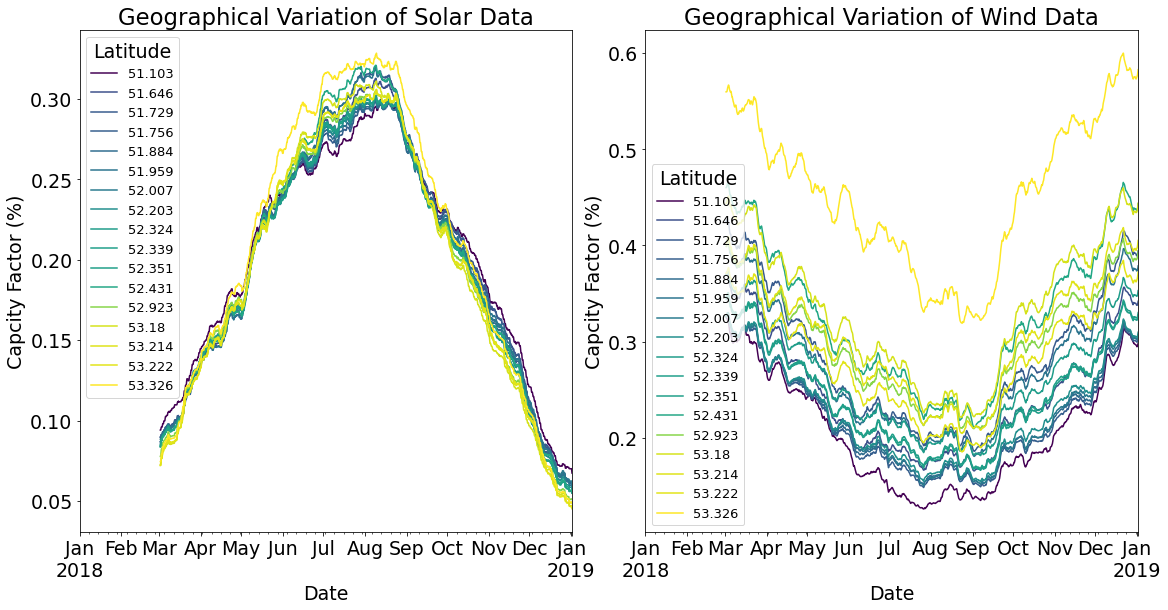

In [10]:
def geographic_variation_plot(directory_name, title, save_name, ax):
    coordinates = get_coordinates(directory_name)
    norm = mpl.colors.Normalize(vmin=coordinates[0][0], vmax=coordinates[-1][0])
    colors = plt.cm.viridis([norm(coord[0]) for coord in coordinates])
    # colors
    for i in range(len(os.listdir(directory_name))):
        df = parse_data(directory_name+os.listdir(directory_name)[i])
        df.rolling(1440).mean().plot(ax =ax, c =colors[i])  # Make the data rolling to reduce short term fluctuations
        ax.legend([coord[0] for coord in coordinates], prop={'size': 13}, title = 'Latitude')
        ax.set_xlabel('Date')
        ax.set_ylabel('Capcity Factor (%)')
    ax.set_title(title)

fig, ax = plt.subplots(1,2, figsize = (16,8))
plt.savefig("Solar&Wind.png", dpi = 300)
fig.tight_layout()

geographic_variation_plot("./pvdata/", 
                          "Geographical Variation of Solar Data", 
                          "./Plots/PVGeographicalVariation.png", 
                          ax =ax[0])
geographic_variation_plot("./winddata/", 
                          "Geographical Variation of Wind Data", 
                          "./Plots/WindGeographicalVariation.png", 
                          ax[1])

Looking between 2018 and 2019 I notice the following:
1. Significant variation of wind generation deoending on the latitude, with locations more north having significantly more potential to capture wind power
2. Strong complementarity between wind and solar. The wind farm fluctuates from an average maximum CF of 40% in winter to 25% in summer. While the solar data fluctuates from a minimum of 5% CF in winter to 30% in summer.

I will analyze the second point in more detail to address just how much complementarity exist between the two. If I look at one of the point locations, I will further analyze how complementary these profiles are:

Complimentarity can be defined in many ways, but for the purpose of this project, I will consider complimentarity as being how *flat* the overall generation profile is when adding the solar power to the wind power.
Below I measure the complementarity by considering a mixture of wind turbines and solar panels on a given hybrid park, it can be seen that as we vary the number of solar panels and wind turbines, the complimentarity changes. What is the sweet spot?

In [26]:
def plot_complementarity(fig, ax, num_wind_turbines=1, num_solar_panels=10):
    df_wind = parse_data("./winddata/winddata_52.324_5.600.csv")
    df_pv = parse_data("./pvdata/pvdata_52.324_5.600.csv")
    df_wind.rolling(1440).mean().plot(ax=ax[0])  # Make the data rolling to reduce short term fluctuations
    df_pv.rolling(1440).mean().plot(ax=ax[0])  # Make the data rolling to reduce short term fluctuations
    df_complementarity = ((1000*num_wind_turbines*df_wind+1*num_solar_panels*df_pv)/(1000*num_wind_turbines+1*num_solar_panels))
    df_complementarity.rolling(1440).mean().plot(ax=ax[0])
    ax[0].legend(["Wind CF", "Solar CF", "Complementarity"])
    month_vals = measure_stationarity(df_complementarity)
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Capacity Factor (%)')
    month_vals.plot.bar(ax = ax[1])
    ax[1].set_title("Complimentarity, Monthly Averages. Std. Deviation = {:.2f}".format(month_vals.std()['electricity']))
    fig.tight_layout()

def measure_stationarity(df):
    df = df.groupby(by=[df.index.month])
    mean = df.mean()
    return mean

# plot_complementarity(num_wind_turbines=2, num_solar_panels=2000)



Looking into the complimentarity with a bit more detail, what is the perfect number of solar panels and wind turbines that optimizes the complimentarity?
I will use the PuLP optimizer to answer this question

Next I want to look at daily variation for both solar and wind!

In [1]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=np.arange(0, 10, 0.01),
            y=np.sin(step * np.arange(0, 10, 0.01))))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

In [34]:
df_wind = parse_data("./winddata/winddata_52.324_5.600.csv")
df_pv = parse_data("./pvdata/pvdata_52.324_5.600.csv")

import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

for step in np.arange(100, 1000, 300):
    fig.add_trace(
        go.Scatter(
            visible=False,
            name="𝜈 = " + str(step),
            x=list(df_pv.index.month),
            y=df_wind))
    fig.add_trace(
        go.Scatter(
            visible=False,
            name="𝜈 = " + str(step),
            x=list(df_pv.index.month),
            y=df_pv))
    df_complementarity = ((1000*2*df_wind+1*step*df_pv)/(1000*2+1*step))
    fig.add_trace(
        go.Scatter(
            visible=False,
            name="𝜈 = " + str(step),
            x=list(df_pv.index.month),
            y=df_complementarity))
fig.update_layout(xaxis_range=[0,12])


# # Make 10th trace visible
fig.data[2].visible = True

# # Create and add slider
steps = []
for i in range(int(len(fig.data)/3)):
    step = dict(
        method="update",
        args=[{"visible": [True] * int(len(fig.data)/3)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    # step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()


In [21]:
list(df_pv.index.month)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


C:\Users\joshb\AppData\Local\Temp/ipykernel_11416/399955616.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear
C:\Users\joshb\AppData\Local\Temp/ipykernel_11416/399955616.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear


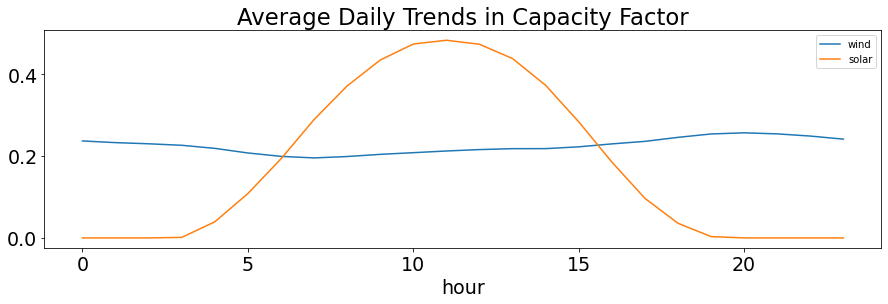

In [9]:
## Looking at daily patterns of data
def daily_trend_plot(df, ax):
    """ Take on a timeseries dataframe and plot the average daily trend """
    df['dow'] = df.index.dayofweek
    df['doy'] = df.index.dayofyear
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['hour'] = df.index.hour
    df['woy'] = df.index.weekofyear
    df['dom'] = df.index.day # Day of Month
    dowdict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    df['weekday'] = df['dow'].map(dowdict)
    df.pivot_table(index='hour', 
                #    columns='weekday', 
                   values='electricity',
                   aggfunc='mean').plot(ax=ax,
                   title='Average Daily Trends in Capacity Factor')
    # return df
fig, ax = plt.subplots(figsize=(15,4))

daily_trend_plot(parse_data("./winddata/"+os.listdir("./winddata")[0]), ax =ax)
daily_trend_plot(parse_data("./pvdata/"+os.listdir("./pvdata")[0]), ax =ax)
ax.legend(['wind','solar'],prop = {'size':10})
plt.savefig("./Plots/AvDailyTrends.png", dpi=300)

At first glance, there doesn't seem to be significant complementarity between the solar and wind generation profiles on a daily scale